# SemiConductor Stock Market Analysis 


In [22]:
# Use Yahoo Finance to collect stock information
# Use LSTM to collect and predict future stock prices
# Introduction of other factors to the stock analysis process

# stock market prediction based on the performance of other stocks in the market in the same category

# Focus will be AMD

# depending on the perforamnce of other stocks such as Nvidia, Intel, etc. then the output should change

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

# yf.pdr_override() # deprecated

# Stock Prediction with LSTM 

Use just the stock's closing price to predict the next opening price

In [24]:
def preprocess_data(stock_symbol, epochs=100, batch_size=32, window_size=60):
    # Fetch data
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)

    # Fetch data for multiple stocks for the last 5 years
    df = yf.download(stock_symbol, start=start, end=end)

    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * .95))

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size])

    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    test_data = scaled_data[training_data_len - window_size:, :]
    test_set = []
    for i in range(window_size, len(test_data)):
        test_set.append(test_data[i-window_size:i, 0])

    test_set = np.array(test_set)
    test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1))

    prediction = model.predict(test_set)
    scaled_pred = scaler.inverse_transform(prediction)

    # Prepare results
    valid = data[training_data_len:]
    valid['Predictions'] = scaled_pred

    return df, valid, scaled_pred

In [ ]:
df_nvda_5, valid_nvda, pred_nvda = preprocess_data('NVDA')


[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 12ms/step


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [77]:
valid_nvda

,Close,Predictions
Date,,
2024-09-05,107.209999,107.479233
2024-09-06,102.830002,107.225449
2024-09-09,106.470001,105.036743
2024-09-10,108.099998,106.505859
2024-09-11,116.910004,108.658989
...,...,...
2024-11-25,136.020004,142.655502
2024-11-26,136.919998,137.025482
2024-11-27,135.339996,135.937149


In [105]:
r2 = r2_score(valid_nvda['Close'], valid_nvda['Predictions'])
print(f'R² Score: {r2}')

R² Score: 0.9207321688454404


In [79]:
current_price = df_nvda_5['Close'].iloc[-1]
threshold = 0.03

# predicted_price = float(pred_nvda[-1])
predicted_price = valid_nvda['Predictions'].iloc[-1]

# if predicted_price > current_price * (1 + threshold):
#     print("Consider buying the stock.")
# elif predicted_price < current_price * (1 - threshold):
#     print("Consider selling the stock.")
# else:
#     print("Hold the stock.")

# Decision logic
price_change = (predicted_price - current_price) / current_price  # Calculate % change
if price_change > threshold:
    action = "Buy"
elif price_change < -threshold:
    action = "Sell"
else:
    action = "Hold"

# Print the decision
print(f"Predicted Price: ${predicted_price:.2f}")
print(f"Current Price: ${current_price:.2f}")
print(f"Price Change: {price_change:.2%}")
print(f"Decision: {action}")

Predicted Price: $137.17
Current Price: $138.63
Price Change: -1.05%
Decision: Hold


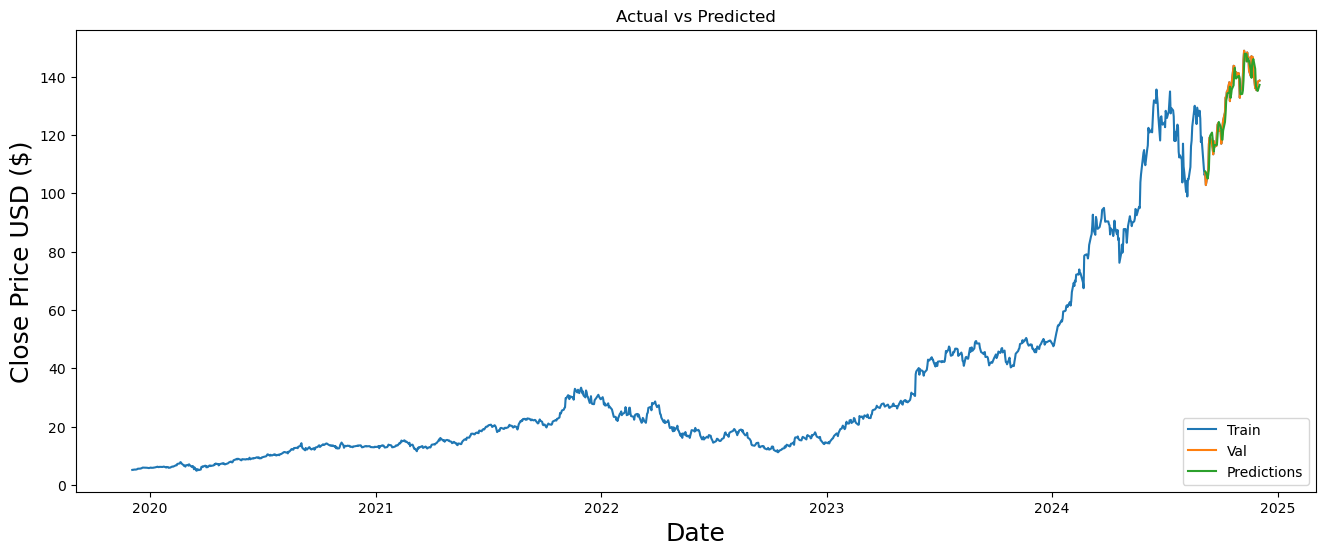

In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(df_nvda_5['Close'])
plt.plot(valid_nvda[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Stock prediction with other stocks
Modify model to take predictions of last relevant stocks to influence price calculation

In [88]:
# use the Nasdaq index as a macroeconomic indicator
# add additional averages, RSI, or bollinger bands as features

# stock prediction focuses semiconductor stocks

# semiconductor stocks
# nvidia, taiwan semiconductor manufacturing, intel, broadcom, qualcomm, AMD

# 5 years
stock_list = ['NVDA','TSM', 'AVGO', 'QCOM', 'AMD']

target_symbol = 'NVDA'

In [89]:
# Fetch data for multiple stocks for 5 years
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch data for multiple stocks for the last 5 years
data = yf.download(stock_list, start=start, end=end)

# data.head()

stock_data = data['Close']

[*********************100%%**********************]  5 of 5 completed


In [90]:
# Separate the target stock (NVDA) and other stocks
target_data = stock_data[target_symbol]  # The target stock data (NVDA)
other_stocks_data = stock_data.drop(columns=[target_symbol])  # All other stocks

# Combine the data: We want the target stock's history based on all other stocks
dataset = pd.concat([other_stocks_data, target_data], axis=1).values

In [91]:
# dataset, target_data = fetch_stocks(stock_list, 'NVDA')

# Calculate the length for training data
training_data_len = int(np.ceil(len(dataset) * .95))

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [92]:
window_size = 60 # number of days to consider

# Prepare the feature (X) and target (y) sequences
X, y = [], []
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size, :-1])  # All stock data for the window, excluding target stock
    y.append(scaled_data[i+window_size, -1])  # Target stock's next day close price (last column)


# Convert the lists into numpy arrays
X, y = np.array(X), np.array(y)

In [93]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


In [95]:
epochs = 100
batch_size = 32

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

In [96]:
# Make predictions
test_data = scaled_data[training_data_len - window_size:, :]
test_set = []
for i in range(window_size, len(test_data)):
    test_set.append(test_data[i - window_size:i, :-1])  # Use the history of other stocks

test_set = np.array(test_set)
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], test_set.shape[2]))

In [97]:
# Prediction
prediction = model.predict(test_set)

# Reshape the prediction to (num_samples, 1) for inverse transformation
prediction = prediction.reshape(-1, 1)  # Flatten the output for inverse transformation

# Inverse transform the predictions for the target stock (the last column)
scaled_pred = scaler.inverse_transform(np.hstack([np.zeros((prediction.shape[0], scaled_data.shape[1] - 1)), prediction]))

# Prepare results for the target stock
valid = target_data[training_data_len:]
valid = valid.to_frame()  # Convert to DataFrame, in the case the data is a series
valid['Predictions'] = scaled_pred[:, -1]  # Only take the last column for the target stock

2/2 [==============================] - 1s 12ms/step


In [98]:
valid.head()

,NVDA,Predictions
Date,,
2024-09-05,107.209999,111.776005
2024-09-06,102.830002,110.717924
2024-09-09,106.470001,108.680985
2024-09-10,108.099998,107.937598
2024-09-11,116.910004,108.310205


In [99]:
r2 = r2_score(valid['NVDA'], valid['Predictions'])
print(f'R² Score: {r2}')

R² Score: 0.8515149629107401


Observations: 
Makes predictions for the target stock in the past 5 years and use of other stocks to compare prices and adjust final prediction. R2 score is 0.78. This indicates that the model is fairly accurate in predicting the target stock's price. However, it's important to note that this model doesn't take into account other factors such as market trends, only comparing and measuring prices of other stocks to adjust its final decision.

In [100]:
# Extract the last prediction as a scalar value
# predicted_price = scaled_pred[-1, 0] 
predicted_price = valid['Predictions'].iloc[-1]

# Get the current price (last adjusted close price)
current_price = data['Close']['NVDA'].iloc[-1]

# Define the threshold
threshold = 0.03  # 3% threshold for decision making

# Decision logic
price_change = (predicted_price - current_price) / current_price  # Calculate % change
if price_change > threshold:
    action = "Buy"
elif price_change < -threshold:
    action = "Sell"
else:
    action = "Hold"

# Print the decision
print(f"Predicted Price: ${predicted_price:.2f}")
print(f"Current Price: ${current_price:.2f}")
print(f"Price Change: {price_change:.2%}")
print(f"Decision: {action}")


Predicted Price: $136.24
Current Price: $138.63
Price Change: -1.72%
Decision: Hold


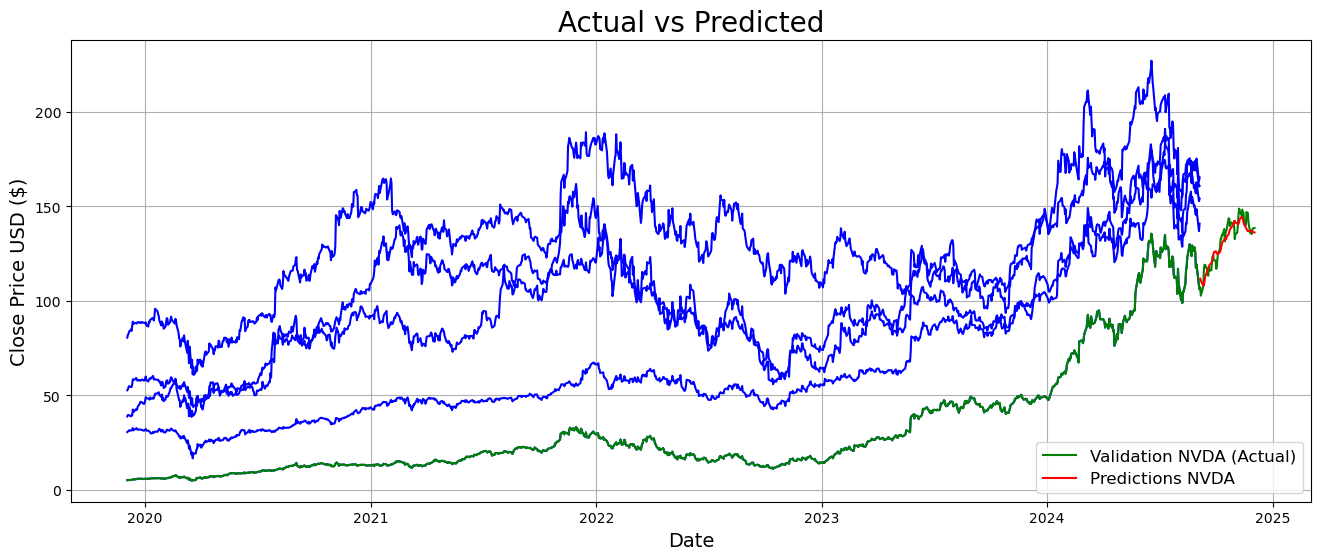

In [104]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)

plt.plot(data[:training_data_len]['Close'], color='blue')
plt.plot(data['Close']['NVDA'], label='Validation NVDA (Actual)', color='green')
plt.plot(valid['Predictions'], label='Predictions NVDA', color='red')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()